# Exploration of syntactic variations of Biblical Hebrew participles

*Chrisitan Højgaard Jensen*

This notebook is part of an ongoing research project with the ultimate goal to cluster Biblical Hebrew verbs according to *Aktionsart* (also called situation aspect). It is the contention of this research that the *Aktionsart* of verbs are sometimes explicated by the presence of certain syntactic elements. For instance, Accomplishment verbs may be distinguished from Stative verbs by the appearance of a temporal or locational phrase, referring to a temporal or geographical endpoint of the event described by the verb. Accordingly, it may be possible to identify the *Aktionsart* of specific verbs by clustering the verbs according to significant syntactic entities.

This notebook is about participles in the Hebrew Bible. Participles are generally regarded as implying the aspect of duration in contrast to punctuality. This aspect is important to sort out in order to classify Biblical Hebrew verbs according to *Aktionsart*.

In this notebook, I will test four hypotheses that occur (frequently) in grammars of Biblical Hebrew:
1. Presumed active verbs occur more often as predicative participles than stative verbs
2. Stative verbs occur more often as adjectival participles than predicative participles
3. Stative verbs occur more often in the sequence subject-participle than in the sequence participle-subject
4. Durative and non-punctual verbs occur more often in the constellation היה + ptc. than punctual verbs.

**Content:**
1. Preparation of data set
2. Exploration of the 10 most frequent active participles
3. Cluster analysis

## 1. Preparation of data set

In [ ]:
repos <- 'http://cran.us.r-project.org'

install.packages("fpc", repo = repos)
install.packages("pvclust", repo = repos)
install.packages("devtools", repo = repos)
devtools::install_github("kassambara/factoextra")

In [2]:
data <- read.csv("participles.csv", header = TRUE)

str(data)
head(data)

'data.frame':	9701 obs. of  12 variables:
 $ node      : int  27 90 187 191 210 216 395 530 586 599 ...
 $ book      : Factor w/ 39 levels "1_Chronicles",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ chapter   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ verse     : int  2 6 11 11 12 12 21 26 28 29 ...
 $ language  : Factor w/ 2 levels "Aramaic","Hebrew": 2 2 2 2 2 2 2 2 2 2 ...
 $ lex       : Factor w/ 906 levels "<BD[","<BR[",..: 692 110 897 12 897 12 670 670 670 897 ...
 $ pred      : Factor w/ 434 levels "","<BD[","<BR[",..: 1 151 1 1 1 1 1 1 1 1 ...
 $ word_order: Factor w/ 11 levels "ptc","ptc-ptc",..: 9 1 1 1 1 1 1 1 1 1 ...
 $ tense     : Factor w/ 2 levels "ptca","ptcp": 1 1 1 1 1 1 1 1 1 1 ...
 $ stem      : Factor w/ 18 levels "haf","hif","hit",..: 13 2 2 16 2 16 16 16 16 16 ...
 $ type      : Factor w/ 4 levels "adjv","advb",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ func      : Factor w/ 13 levels "Adju","Cmpl",..: 8 8 8 8 8 8 8 8 8 8 ...


node,book,chapter,verse,language,lex,pred,word_order,tense,stem,type,func
27,Genesis,1,2,Hebrew,RXP[,,S-ptc,ptca,piel,verb,PreC
90,Genesis,1,6,Hebrew,BDL[,HJH[,ptc,ptca,hif,verb,PreC
187,Genesis,1,11,Hebrew,ZR<[,,ptc,ptca,hif,verb,PreC
191,Genesis,1,11,Hebrew,<FH[,,ptc,ptca,qal,verb,PreC
210,Genesis,1,12,Hebrew,ZR<[,,ptc,ptca,hif,verb,PreC
216,Genesis,1,12,Hebrew,<FH[,,ptc,ptca,qal,verb,PreC


Adding a genre category:

In [3]:
prose <- c('Genesis', 'Exodus', 'Leviticus', 'Numbers', 'Deuteronomy', 'Joshua', 'Judges', '1_Samuel', '2_Samuel', 
           '1_Kings', '2_Kings', 'Jonah', 'Ruth', 'Esther', 'Daniel', 'Ezra', 'Nehemiah', '1_Chronicles', '2_Chronicles')
poetry <- c('Psalms', 'Job', 'Proverbs', 'Song_of_songs', 'Ecclesiastes', 'Lamentations')

data$genre <- ifelse(data$book %in% prose, 'prose',
                   ifelse(data$book %in% poetry, 'poetry','prophecy'))

Stripping last [ of lexemes:

In [4]:
data$lex <- substr(data$lex,1,nchar(as.character(data$lex))-1)
data$pred <- substr(data$pred,1,nchar(as.character(data$pred))-1)

In [5]:
str(data)

'data.frame':	9701 obs. of  13 variables:
 $ node      : int  27 90 187 191 210 216 395 530 586 599 ...
 $ book      : Factor w/ 39 levels "1_Chronicles",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ chapter   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ verse     : int  2 6 11 11 12 12 21 26 28 29 ...
 $ language  : Factor w/ 2 levels "Aramaic","Hebrew": 2 2 2 2 2 2 2 2 2 2 ...
 $ lex       : chr  "RXP" "BDL" "ZR<" "<FH" ...
 $ pred      : chr  "" "HJH" "" "" ...
 $ word_order: Factor w/ 11 levels "ptc","ptc-ptc",..: 9 1 1 1 1 1 1 1 1 1 ...
 $ tense     : Factor w/ 2 levels "ptca","ptcp": 1 1 1 1 1 1 1 1 1 1 ...
 $ stem      : Factor w/ 18 levels "haf","hif","hit",..: 13 2 2 16 2 16 16 16 16 16 ...
 $ type      : Factor w/ 4 levels "adjv","advb",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ func      : Factor w/ 13 levels "Adju","Cmpl",..: 8 8 8 8 8 8 8 8 8 8 ...
 $ genre     : chr  "prose" "prose" "prose" "prose" ...


### 1.1 Overview of the data

There is no simple relationship between participle types and function. Predicative participles occur only as PreC (predicate complement) and PtcO (participle with suffixed object), whereas substantival and adjectival particples occur with many different syntactic functions.

In [6]:
table(data$type,data$func)

      
       Adju Cmpl Frnt Loca Modi Objc PrAd PreC PreO PtcO Subj Time Voct
  adjv   79   80   11    8    0  157   45  297    0    0  105    3    5
  advb    0    0    0    0    3    1    0    0    0    0    0    0    0
  subs  268  603   42   13    2  627    5  456    3    0 1127    5   92
  verb    0    0    0    0    0    0    0 5501    0  163    0    0    0

In [7]:
#Type:
table(data$type)


adjv advb subs verb 
 790    4 3243 5664 

In [8]:
#Word order:
table(data$word_order)


            ptc         ptc-ptc     ptc-ptc-ptc ptc-ptc-ptc-ptc       ptc-ptc-S 
           4909             364              48              12              20 
          ptc-S       ptc-S-ptc               S           S-ptc       S-ptc-ptc 
            558              14            1136            2490             138 
  S-ptc-ptc-ptc 
             12 

In [9]:
#Language:
table(data$language)


Aramaic  Hebrew 
    306    9395 

### 1.2 Trimming data set

The data set is trimmed for infrequent values, since those values have very little significant as regards major trends in the data. Moreover, only the Hebrew part of the Hebrew Bible is taken into account here, so the participles from the Aramaic part are stripped.

In [10]:
#Excluding Aramaic:
data2 <- droplevels(data[data$language == "Hebrew",])

#Excluding infrequent constellations
freq_min <- 100

for (i in 8:12){ #The loop runs through columns 8-12
    var.data.frame <- as.data.frame(table(data2[,i])) #The column is transformed, first, into a table and, then, a dataframe.
    retain.levels <- var.data.frame[which(var.data.frame$Freq > freq_min),] #A subset of values occuring more than 100
                                                                            #times is created
    data2 <- data2[data2[,i] %in% retain.levels$Var1, ] #The data-set is trimmed according to the subset created above.
    data2 <- droplevels(data2)
}

In [11]:
str(data2)

'data.frame':	9036 obs. of  13 variables:
 $ node      : int  27 90 187 191 210 216 395 530 586 599 ...
 $ book      : Factor w/ 39 levels "1_Chronicles",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ chapter   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ verse     : int  2 6 11 11 12 12 21 26 28 29 ...
 $ language  : Factor w/ 1 level "Hebrew": 1 1 1 1 1 1 1 1 1 1 ...
 $ lex       : chr  "RXP" "BDL" "ZR<" "<FH" ...
 $ pred      : chr  "" "HJH" "" "" ...
 $ word_order: Factor w/ 6 levels "ptc","ptc-ptc",..: 5 1 1 1 1 1 1 1 1 1 ...
 $ tense     : Factor w/ 2 levels "ptca","ptcp": 1 1 1 1 1 1 1 1 1 1 ...
 $ stem      : Factor w/ 7 levels "hif","hit","hof",..: 5 1 1 7 1 7 7 7 7 7 ...
 $ type      : Factor w/ 3 levels "adjv","subs",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ func      : Factor w/ 6 levels "Adju","Cmpl",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ genre     : chr  "prose" "prose" "prose" "prose" ...


In [12]:
table(data2$type,data2$func)

      
       Adju Cmpl Objc PreC PtcO Subj
  adjv   74   69  152  270    0  103
  subs  260  571  600  452    0 1120
  verb    0    0    0 5202  163    0

## 2. Exploration of the 10 most frequent participles

The procedure of the explorative analysis of this notebook is, first, to observe trends among the 10 most frequent participles which account for 2059 instances. Secondly, a larger number of lexemes is included.

In [13]:
top.lexemes <- 10

lex <- as.data.frame(table(data2$lex))
lex <- lex[order(- lex$Freq),] 

top.lex <- droplevels(lex[1:top.lexemes,])
top.lex

,Var1,Freq
308,JCB,466
128,BW>,283
63,>JB,271
10,<FH,254
290,HLK,172
336,JY>,145
486,NTN,126
366,KTB,119
19,<MD,118
457,NF>,105


In [14]:
data.top10 <- droplevels(data2[data2$lex %in% top.lex$Var1, ])
str(data.top10)

'data.frame':	2059 obs. of  13 variables:
 $ node      : int  191 216 865 935 1321 2011 2916 3355 4209 4250 ...
 $ book      : Factor w/ 38 levels "1_Chronicles",..: 15 15 15 15 15 15 15 15 15 15 ...
 $ chapter   : int  1 1 2 2 3 4 6 7 9 9 ...
 $ verse     : int  11 12 10 14 8 20 17 16 10 12 ...
 $ language  : Factor w/ 1 level "Hebrew": 1 1 1 1 1 1 1 1 1 1 ...
 $ lex       : chr  "<FH" "<FH" "JY>" "HLK" ...
 $ pred      : chr  "" "" "" "" ...
 $ word_order: Factor w/ 6 levels "ptc","ptc-ptc",..: 1 1 5 1 1 5 1 1 1 5 ...
 $ tense     : Factor w/ 2 levels "ptca","ptcp": 1 1 1 1 1 1 1 1 1 1 ...
 $ stem      : Factor w/ 6 levels "hif","hit","hof",..: 6 6 6 6 2 6 1 6 6 6 ...
 $ type      : Factor w/ 3 levels "adjv","subs",..: 3 3 3 3 3 2 3 3 3 3 ...
 $ func      : Factor w/ 6 levels "Adju","Cmpl",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ genre     : chr  "prose" "prose" "prose" "prose" ...


### 2.1 Top-10 lexemes in relation to participle type

In [15]:
library("vcd");

Warning message:
"package 'vcd' was built under R version 3.4.2"Loading required package: grid


Only active participles in *Qal* are included:

In [16]:
top10.qal <- droplevels(data.top10[data.top10$stem == "qal" & data.top10$tense == "ptca",])
matrix(c("Number of top-10 participles in Qal:",nrow(top10.qal)), 1)

Number of top-10 participles in Qal:,1767


An associate plot is created to compare the relative distribution of adjectival, substantival and predicate participles:

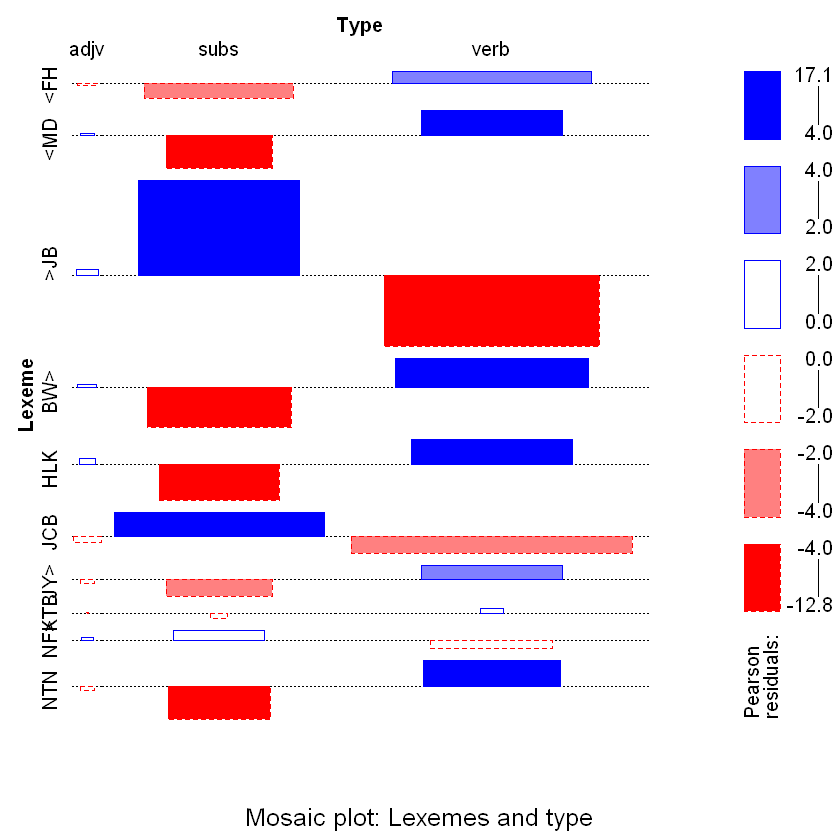

In [17]:
lex.type <- structable(top10.qal$lex,top10.qal$type)

assoc(lex.type, split_vertical = F, gp = shading_Friendly, legend = legend_fixed, sub = "Mosaic plot: Lexemes and type",
      labeling_args = list(set_varnames = c(A = "Lexeme", B = "Type")))

It is evident that the verbs איב "be hostile" (>JB) and ישׁב "sit/dwell" (JCB), and to a lesser extent נשׂא "to carry" (NF>) differ remarkably from the other verbs in that they occur far less as verbs. This is interesting, since איב and ישׁב are expected to be stative verbs.

This tendency justifies a closer look at the relative distribution of participle type among a larger quantity of lexemes.

### 2.2 All participles occuring 19+ times in relation to participle type

In [18]:
min.freq <- 20

lex <- as.data.frame(table(data2$lex))
lex <- lex[order(- lex$Freq),]

top.lex <- droplevels(lex[lex$Freq >= min.freq,])

data.top.lex <- droplevels(data2[data2$lex %in% top.lex$Var1,])

In [19]:
table(data.top.lex$lex)


 <BD  <BR  <FH  <LH  <MD  <ZB  <ZR  >HB  >JB  >KL  >MN  >MR  >RB  >RR  BGD  BJN 
  29  100  254   83  118   28   23   76  271   68   41   99   22   50   21   47 
 BLL  BNH  BQC  BRK  BVX  BW>  BXR  C>R  CDD  CJR  CKB  CKN  CLX  CM<  CMM  CMR 
  38   32   61   80   33  283   25   44   22   47   29   20   56   77   27   99 
 CPV  CRT  CVR  CWB  CXT  CZR  DBR  DRC  FJM  FKL  FN>  G>L  GWR  HLK  J<Y  JC< 
  67   42   25   38   20   21   83   23   20   21   76   47   33  172   31   33 
 JCB  JD<  JLD  JR>  JRD  JTR  JY>  JYR  KBD  KSH  KTB  KWN  LXM  MCL  ML>  MWT 
 466   95   55   58   47   51  145   24   24   25  119   39   24   41   52  100 
 MY>  NB>  NF>  NG<  NGD  NKH  NPL  NTN  NVH  NYB  NYL  NYX  P<L  PL>  PNH  PQD 
  54   39  105   46   20   44   42  126   43   45   20   60   27   46   23   93 
 QDC  QR>  QVR  QWM  R<H  R>H  RDP  RKB  RWC  RWM  RWY  RYX  XCB  XLH  XTN  XZQ 
  24   41   21   34   97   85   41   37   22   36   32   34   28   24   22   25 
 YPH YRR=  YWH  ZBX  ZNH  Z

Again, only active participles in *qal* are included:

In [20]:
data.top.lex.qal <- droplevels(data.top.lex[data.top.lex$stem == "qal" & data.top.lex$tense == "ptca",])

A table containing the proportions of participle types for each particle is made:

In [21]:
data2.lex.type <- table(data.top.lex.qal$lex,data.top.lex.qal$type)

type.prop <- prop.table(data2.lex.type, 1)
type.prop[1:5,]

     
             adjv        subs        verb
  <BD 0.035714286 0.500000000 0.464285714
  <BR 0.082474227 0.237113402 0.680412371
  <FH 0.004291845 0.248927039 0.746781116
  <LH 0.018518519 0.055555556 0.925925926
  <MD 0.008620690 0.025862069 0.965517241

The table is first sorted according to the proportions of verb and adjective, respectively, and, secondly, plottet in a barplot:

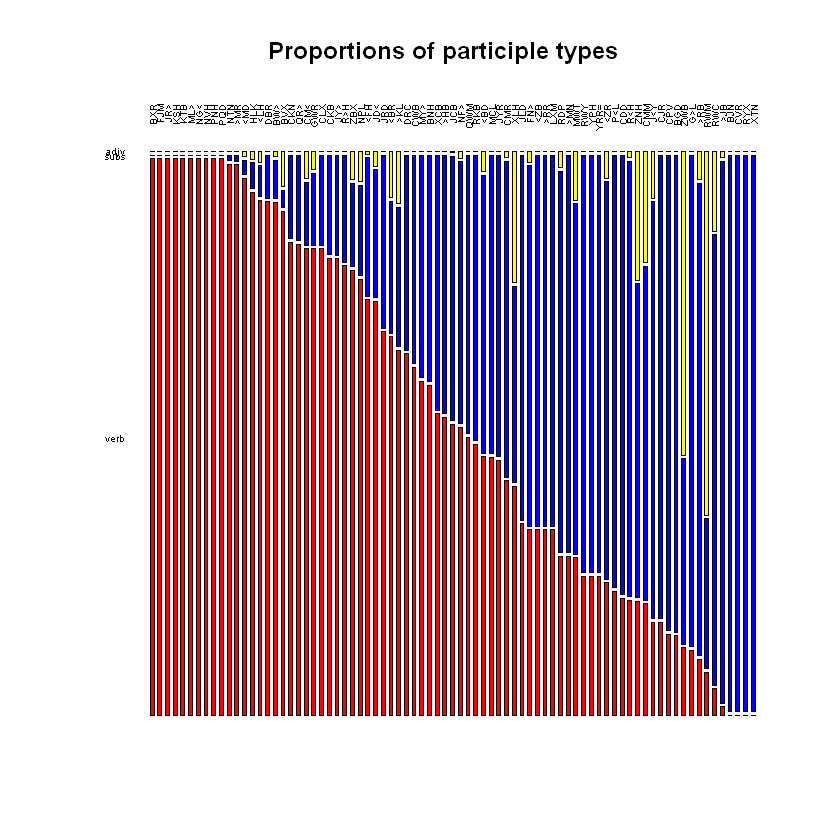

In [22]:
type.prop.order <- type.prop[order(-type.prop[,3],-type.prop[,1]),]

plot(type.prop.order, las=2, main="Proportions of participle types", cex.axis = 0.5,
     col = c("yellow","blue","red"))

The barplot supports the earlier observations that dynamic verbs tend to occur as predicate particles (e.g. שׁים, נגע) while presumably stative verbs like שׁמם, חלה occur more often as adjectives. The same distribution is plotted in the graph below:

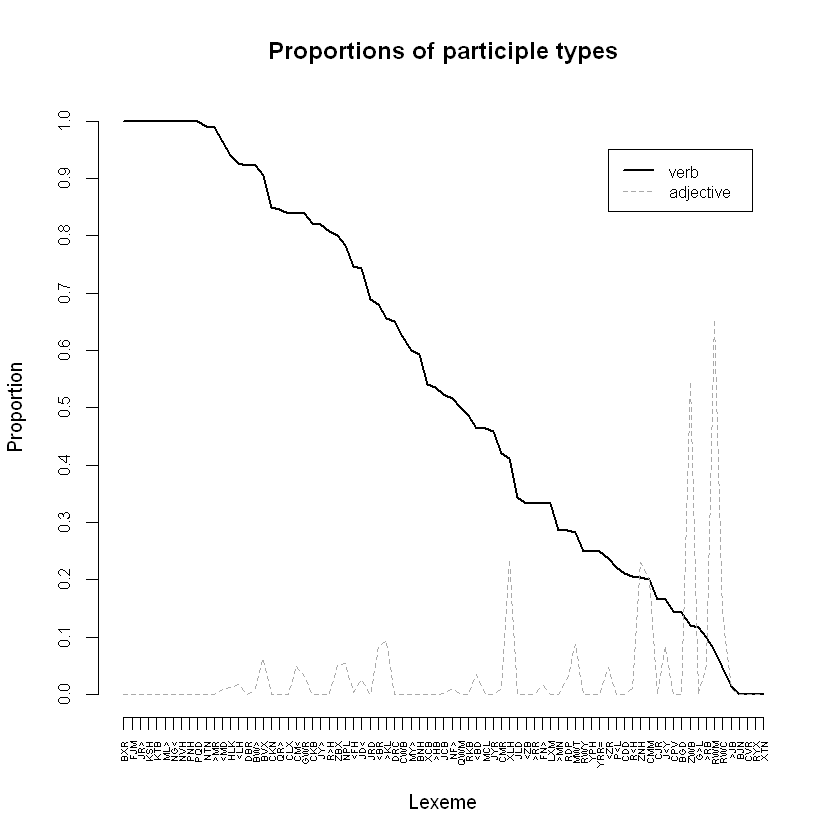

In [23]:
verb.order <- type.prop[order(-type.prop[,3]),]

plot(verb.order[,3], type = "l",ylim = c(0:1), lwd = "2", xlim = c(1,79),
     main = "Proportions of participle types", ylab = "Proportion", xlab = "Lexeme", axes = FALSE)
lines(verb.order[,1], col = "darkgrey", lty=2)
legend(60, 0.95, legend=c("verb","adjective"), col=c("black","darkgrey"), lty=c(1,2), lwd=c(2,1), cex=0.8)
axis(1, at = seq(1,nrow(verb.order)), labels = rownames(verb.order), las=2, cex.axis = 0.5)
axis(2, at=seq(0, 1, by=0.1), cex.axis = 0.8)

### 2.3 Word order of predicative participles

Now the hypothesis that stative verbs occur more often in the sequence subject-particple than vice versa will be tested. First the data set is trimmed, so it only contains predicative participles with an explicit subject in the sequence "participle-subject" or "subject-participle".

In [24]:
data.pred.wo <- droplevels(data2[data2$type == "verb" & data2$word_order %in% c("ptc-S","S-ptc"),])
nrow(data.pred.wo)

[1] 2074

More lexemes are included here to have enough lexemes to compare:

In [25]:
min.freq <- 8

lex <- as.data.frame(table(data.pred.wo$lex))
lex <- lex[order(- lex$Freq),]

top.lex <- droplevels(lex[lex$Freq >= min.freq,])

pred.wo.top.lex <- droplevels(data.pred.wo[data.pred.wo$lex %in% top.lex$Var1,])

table(pred.wo.top.lex$word_order)


ptc-S S-ptc 
  187  1128 

The lexemes and word order are plotted in spineplot sorted according to the proportion of the sequence S-ptc:

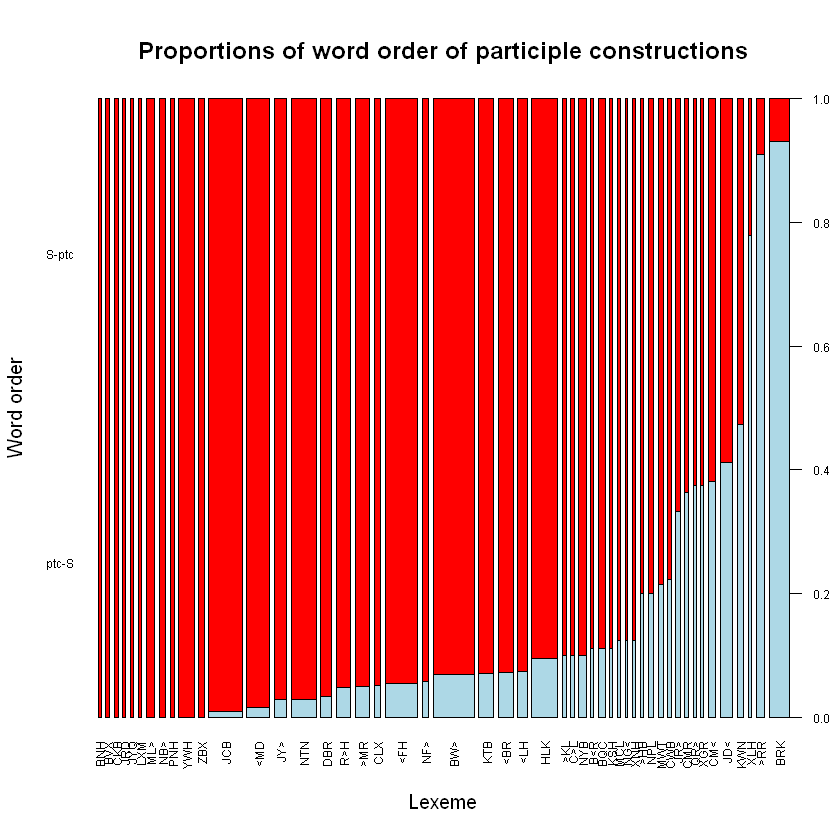

In [26]:
wo.table <- table(pred.wo.top.lex$lex, pred.wo.top.lex$word_order)

#Sorting table accordint to proportion of S-ptc word order
prop.wo <- prop.table(wo.table, 1)
wo.table <- wo.table[order(-prop.wo[,2]),]

par(las = 2, cex.axis = 0.6)
spineplot(wo.table, main="Proportions of word order of participle constructions", off=1,
         xlab = "Lexeme", ylab = "Word order", col=c("lightblue","red"))

It is hardly possible to use word order to distinguish stative verbs from active verbs. On the one hand, XLH "to be weak/sick" occurs about 78% in the S-ptc word order hypothesized as indicative for stative verbs. On the other hand, however, presumably active verbs like BRK "to bless" and >RR "to curse" occur similarly in the S-ptc word order. 

In [27]:
#XLH:
XLH <- droplevels(pred.wo.top.lex[pred.wo.top.lex$lex == "XLH",])
prop.table(table(XLH$word_order))

#JCB:
JCB <- droplevels(pred.wo.top.lex[pred.wo.top.lex$lex == "JCB",])
prop.table(table(JCB$word_order))


    ptc-S     S-ptc 
0.7777778 0.2222222 


    ptc-S     S-ptc 
0.0106383 0.9893617 

### 2.4 With finite היה

Finally, the last hypothesis is to be checked. This hypothesis claims that היה + ptc. implies a durative aspect which would suggest that presumably punctual verbs will not occur - or only infrequent - in this constellation.

The top-10 lexemes are addressed again and a separate column is created. In this column all occurences of היה are registred:

In [28]:
top10.hajah <- droplevels(data.top10[data.top10$tense == "ptca",])

top10.hajah$hajah <- ifelse(top10.hajah$pred == "HJH", "HJH", "")

In [29]:
table(top10.hajah$tense,top10.hajah$hajah)

      
             HJH
  ptca 1840   59

Only 59 instances of this constellation exist among the top-10 lexemes. An association plot is now created to compare the relative distribution of lexemes with a finite HJH:

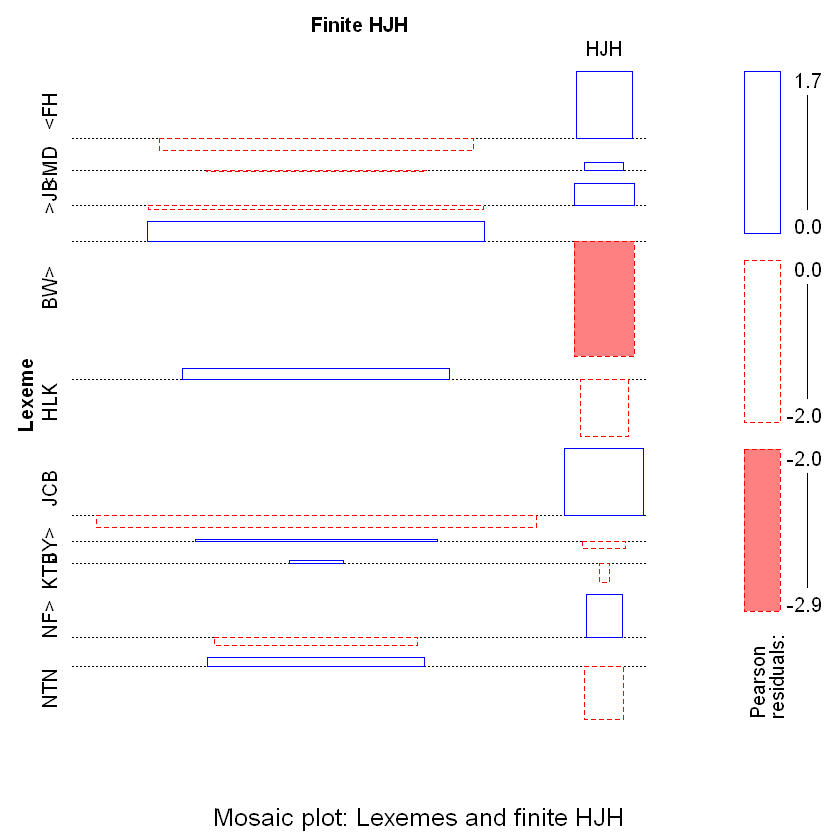

In [30]:
lex.hajah <- structable(top10.hajah$lex,top10.hajah$hajah)

assoc(lex.hajah, split_vertical = F, gp = shading_Friendly, legend = legend_fixed, sub = "Mosaic plot: Lexemes and finite HJH",
      labeling_args = list(set_varnames = c(A = "Lexeme", B = "Finite HJH")))

As the mosaic plot shows, the relative distribution of participles with a finite HJH is relatively consistent regardless of the verb. Nevertheless, it is interesting that constellations with verbs like BW> "to come/arrive" and NTN "to give" plus finite HJH are underrepresented. These verbs may imply an inherent punctual aspect referring to the exact time of arriving and giving.

Now, this tendency will be evaluated with more lexemes:

In [31]:
top.lex.hajah <- droplevels(data.top.lex[data.top.lex$tense == "ptca",])

top.lex.hajah$hajah <- ifelse(top.lex.hajah$pred == "HJH", "HJH", "")

In [32]:
lex.hajah.table <- table(top.lex.hajah$lex,top.lex.hajah$hajah)

#Ordering the table according to proportion of finite HJH
prop.HJH <- prop.table(lex.hajah.table, 1)
lex.hajah.table <- lex.hajah.table[order(-prop.HJH[,2]),]

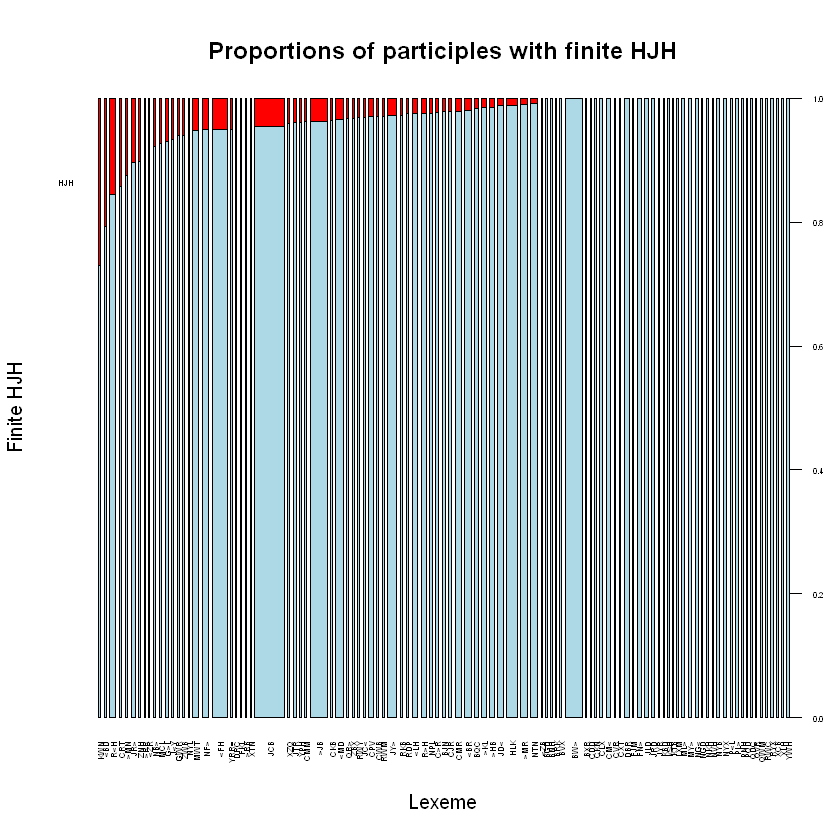

In [33]:
par(las = 2, cex.axis = 0.4)
spineplot(lex.hajah.table, main="Proportions of participles with finite HJH", off=1,
         xlab = "Lexeme", ylab = "Finite HJH", col=c("lightblue","red"))

The spine plot is ordered according to the relative frequency of constellations of participle + finite HJH. The results are not conclusive. For instance, MWT "to die" does occur with HJH, even though "to die" is expected to refer to a rather punctual event. On the other hand, participles like JLD "give birth" and MY> "to find" never occur with a finite HJH, and these verbs are expected to be punctual. Far from being conclusive, therefore, the plot shows interesting trends that may suggest verbal aspect - at least in conjunction with other parameters.

## 3. Cluster analysis

Having identified the relative freqencies of participle type (predicative, adjectival and substantival) and occurence of finite HJH as suggestive, if not indicative, for verbal aspect, it is now time to cluster the verbs according to these parameters.

The cluster analysis conducted in this notebook is inspired by the principle of "hybrid clustering", that is, a combination of hierarchical clustering and k-means clustering:

https://www.r-bloggers.com/hybrid-hierarchical-k-means-clustering-for-optimizing-clustering-outputs-unsupervised-machine-learning/

### 3.1 Preparing data

#### 3.1.1 Combining proportions:

To analyze the data, two extra columns are added to the data set. First, a column is added with the value HJH if a finite HJH occur in conjunction with the participle. Second, a column is added with the value "verb" or "adjv" if the participle type is either verb or adjective, respectively. All participles occuring at least 20 times are included in the analysis.

In [34]:
ptc.data <- data.top.lex

ptc.data$HJH <- ifelse(ptc.data$pred == "HJH" & ptc.data$tense == "ptca", "HJH", "")
ptc.data$qal.type <- ifelse(ptc.data$type == "verb" & ptc.data$tense == "ptca" & ptc.data$stem == "qal", "verb", 
                            ifelse(ptc.data$type == "adjv" & ptc.data$tense == "ptca" & ptc.data$stem == "qal", "adjv", ""))

Proportional tables are calculated for lexemes and HJH, and for lexemes and participle type, respectively:

In [35]:
prop.HJH <- prop.table(table(ptc.data$lex,ptc.data$HJH), 1)
head(prop.HJH)

     
                        HJH
  <BD 0.79310345 0.20689655
  <BR 0.98000000 0.02000000
  <FH 0.95275591 0.04724409
  <LH 0.97590361 0.02409639
  <MD 0.96610169 0.03389831
  <ZB 1.00000000 0.00000000

In [36]:
prop.qal.type <- prop.table(table(ptc.data$lex,ptc.data$qal.type), 1)
head(prop.qal.type)

     
                         adjv        verb
  <BD 0.517241379 0.034482759 0.448275862
  <BR 0.260000000 0.080000000 0.660000000
  <FH 0.311023622 0.003937008 0.685039370
  <LH 0.385542169 0.012048193 0.602409639
  <MD 0.042372881 0.008474576 0.949152542
  <ZB 0.857142857 0.000000000 0.142857143

The two prop. tables are combined:

In [37]:
ptc.prop <- cbind(prop.HJH[,2],prop.qal.type[,3], prop.qal.type[,2])
colnames(ptc.prop) <- c("HJH", "verb", "adjv")
nrow(ptc.prop)
ptc.prop[1:5,]

[1] 102

,HJH,verb,adjv
<BD,0.20689655,0.4482759,0.034482759
<BR,0.02000000,0.6600000,0.080000000
<FH,0.04724409,0.6850394,0.003937008
<LH,0.02409639,0.6024096,0.012048193
<MD,0.03389831,0.9491525,0.008474576


#### 3.1.2 Scaling data

The data are scaled to differentiate the values

In [38]:
ptc.prop <- as.data.frame(ptc.prop)
ptc.prop1 <- scale(ptc.prop)

### 3.2 Hierarchical clustering

First, a hierarchical clustering, based on calculating the euclidean distance between the data points.

In [43]:
library('devtools'); library('factoextra')

Loading required package: ggplot2
Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


In [44]:
res.hc <- eclust(ptc.prop1, "hclust", k = 4, hc_metric = "euclidean",
                method = "ward.D2", graph = FALSE) 

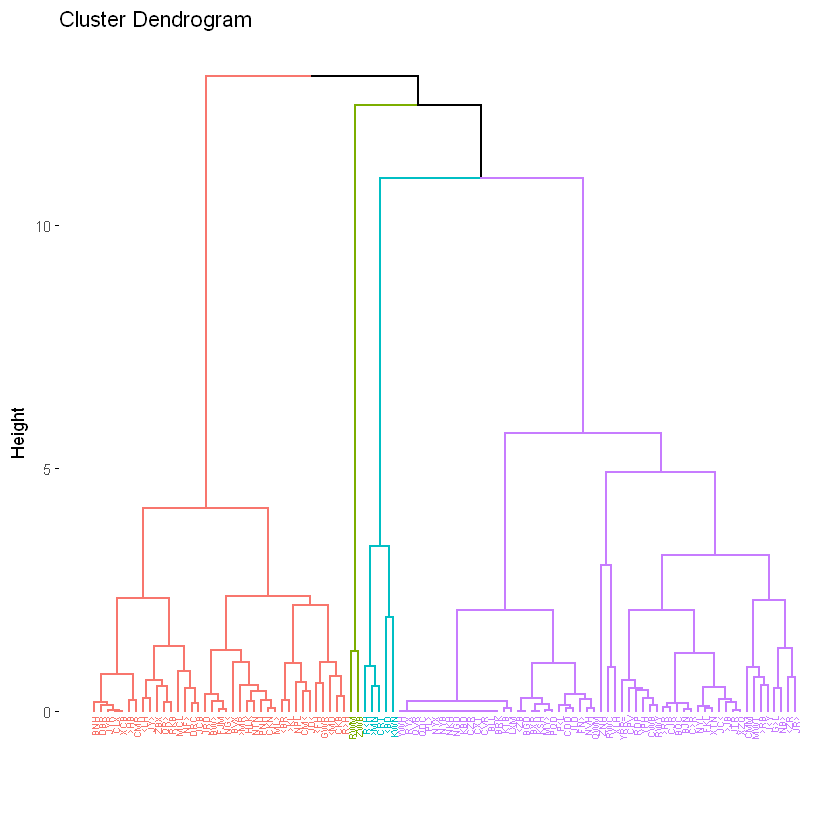

In [45]:
fviz_dend(res.hc, show_labels = TRUE, cex = 0.4)

The consistency of the clustering can be validated by calculating the silhouettes of the clusters. For cluster silhouettes, see https://en.wikipedia.org/wiki/Silhouette_(clustering)

  cluster size ave.sil.width
1       1    5          0.49
2       2   37          0.50
3       3   58          0.49
4       4    2          0.81


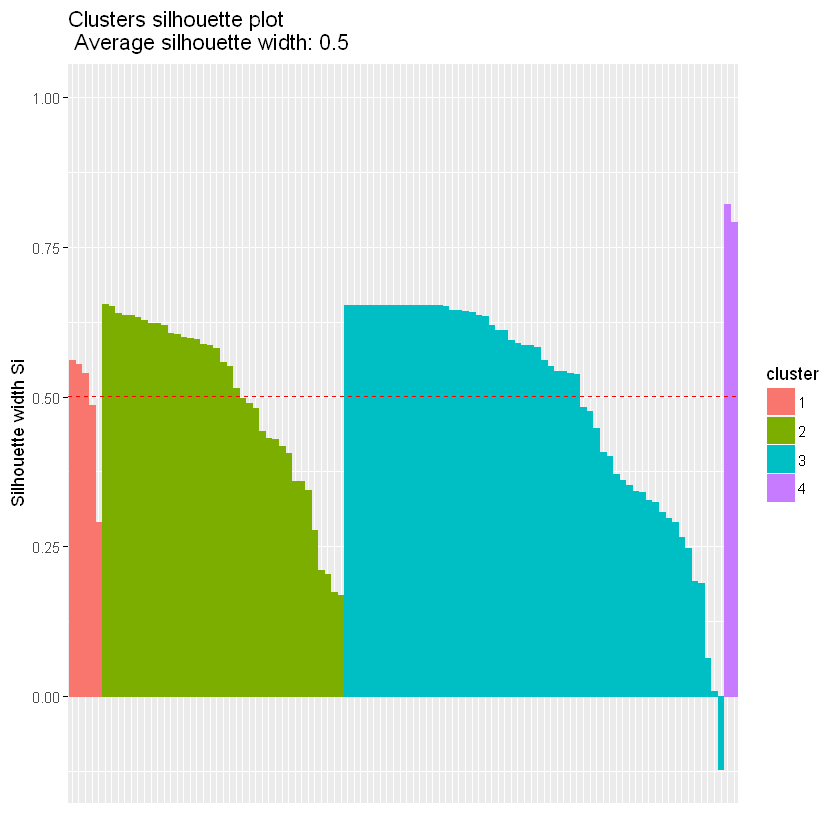

In [46]:
fviz_silhouette(res.hc)

In [47]:
# Silhouette width of observation
sil <- res.hc$silinfo$widths[, 1:3]
# Objects with negative silhouette
neg_sil_index <- which(sil[, 'sil_width'] < 0)
sil[neg_sil_index, , drop = FALSE]

,cluster,neighbor,sil_width
JR>,3,1,-0.1224105


### 3.4 K-means clustering

The K-means clustering is conducted in three steps, using the clusters calculated by the hiearchical clustering as predefined cluster centers:

1. Compute hierarchical clustering and cut the tree into k-clusters
2. Compute the center (i.e the mean) of each cluster
3. Compute k-means by using the set of cluster centers as the initial cluster centers

#### 3.4.1 Compute hierarchical clustering and cut the tree into k-clusters

First, the results of the hiearchical clustering are assigned to a variable:

In [48]:
grp <- res.hc$cluster

#### 3.4.2 Compute the center (i.e the mean) of each cluster

Second, the centers of the clusters are found by calculating the mean of the hiearchical clustering results:

In [49]:
clus.centers <- aggregate(ptc.prop1, list(grp), mean)
clus.centers

Group.1,HJH,verb,adjv
1,3.4404107,-0.5206781,-0.1934643
2,-0.2280156,1.1816056,-0.1475665
3,-0.1639734,-0.6849548,-0.1034396
4,0.3724920,-0.6943197,6.2133902


In [50]:
# Remove the first column
clus.centers <- clus.centers[, -1]
clus.centers

HJH,verb,adjv
3.4404107,-0.5206781,-0.1934643
-0.2280156,1.1816056,-0.1475665
-0.1639734,-0.6849548,-0.1034396
0.3724920,-0.6943197,6.2133902


#### 3.4.3 Compute k-means by using the set of cluster centers as the initial cluster centers

Now, a new k-means clustering can be made, using the calculated cluster centers as predefined centers.

  cluster size ave.sil.width
1       1    8          0.28
2       2   37          0.49
3       3   55          0.56
4       4    2          0.81


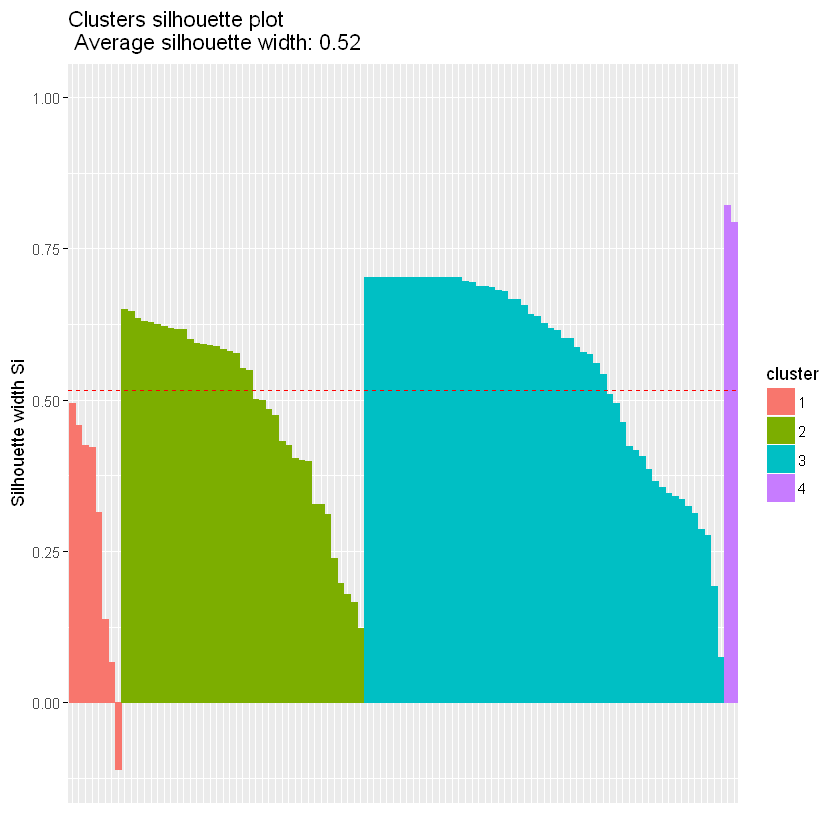

In [53]:
km.res <- eclust(ptc.prop1, "kmeans", k = clus.centers, graph = FALSE)
fviz_silhouette(km.res)

In [54]:
# Silhouette width of observation
sil <- km.res$silinfo$widths[, 1:3]
# Objects with negative silhouette
neg_sil_index <- which(sil[, 'sil_width'] < 0)
sil[neg_sil_index, , drop = FALSE]

,cluster,neighbor,sil_width
<ZR,1,3,-0.1107328


### 3.5 Comparing the results

Finally, the hiearchical clustering and the k-means clustering can be compared by cross-tabulating the data:

In [55]:
# res.hc$cluster: Initial clusters defined using hierarchical clustering
# km.res$cluster: Final clusters defined using k-means
table(km.res$cluster, res.hc$cluster)

   
     1  2  3  4
  1  5  0  3  0
  2  0 37  0  0
  3  0  0 55  0
  4  0  0  0  2

The difference can be visualized using the function fviz_dend() [in factoextra]. The labels are colored using k-means clusters:

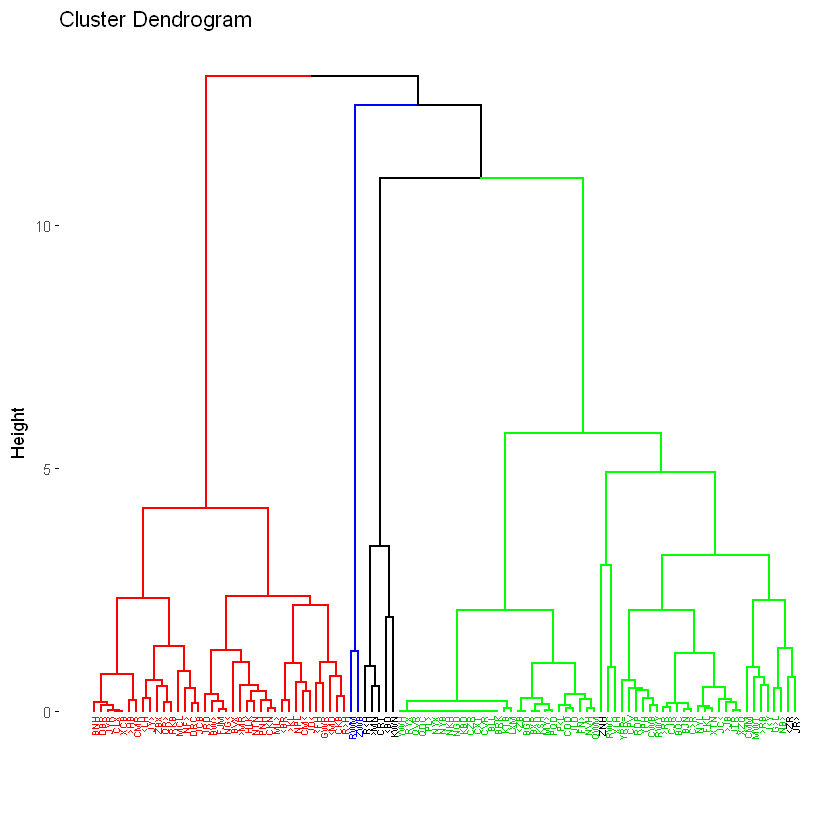

In [56]:
fviz_dend(res.hc,
            k_colors = c("red", "blue", "black", "green"),
          label_cols =  km.res$cluster[res.hc$order], cex = 0.4)

The combined clustering methods enhance the accuracy of the clustering. Here three lexemes are relocated into more fitting clusters. The resulting clusters can be visualized as below:

Too few points to calculate an ellipse


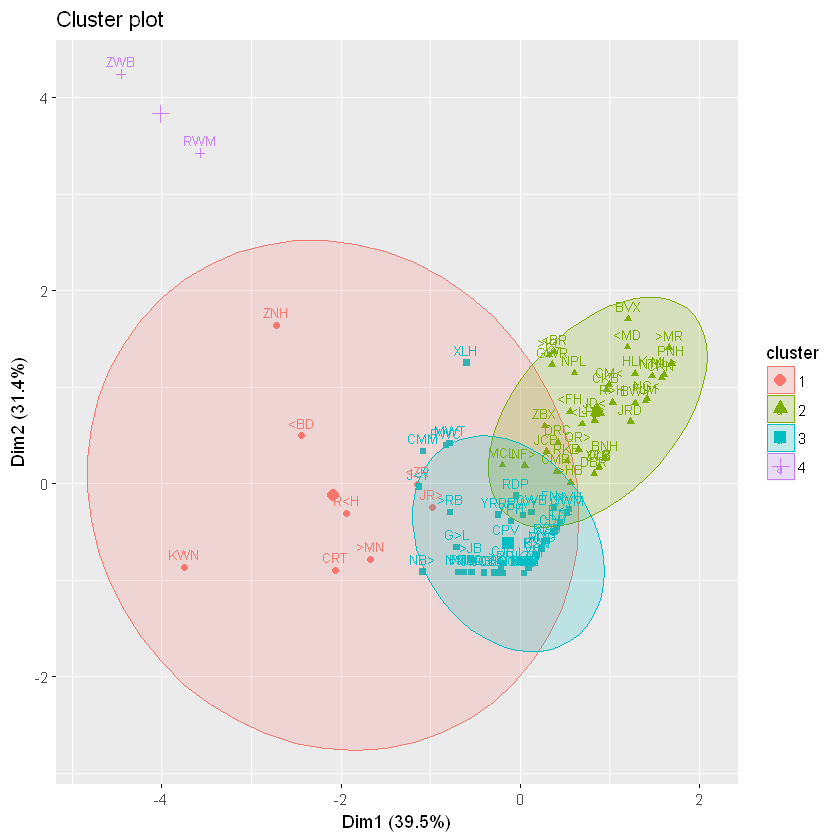

In [57]:
fviz_cluster(km.res, ellipse.type = "norm", ellipse.level = 0.95, labelsize = 8)

## 4. Conclusion

The present notebook has investigated the syntactic variation of participial clauses. Four hypotheses have been testes of which 3 of them were sustained by the data, albeit to different degrees:

1. Presumed active verbs occur more often as predicative participles than stative verbs
2. Stative verbs occur more often as adjectival participles than predicative participles
3. ~~Stative verbs occur more often in the sequence subject-participle than in the sequence participle-subject~~
4. Durative and non-punctual verbs occur more often in the constellation היה + ptc. than punctual verbs.

The cluster analysis also showed that the participle constellations are differentiated enough to suggest clusters. Some verbs expected to belonging to the same *Aktionsart* were also attributed to the same clusters. More parameters might even strengthen that hypothesis and allow more clear clustering.